Scanning folder: C:\Users\Zach/PycharmProjects/1400/LFS Data
Found 13 files. Showing up to first 50: ['pub0125.csv', 'pub0225.csv', 'pub0325.csv', 'pub0425.csv', 'pub0525.csv', 'pub0625.csv', 'pub0725.csv', 'pub0825.csv', 'pub0925.csv', 'pub1024.csv', 'pub1025.csv', 'pub1124.csv', 'pub1224.csv']

File mapping for Oct-2024 -> Oct-2025:
  Oct-24: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub1024.csv
  Nov-24: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub1124.csv
  Dec-24: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub1224.csv
  Jan-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0125.csv
  Feb-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0225.csv
  Mar-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0325.csv
  Apr-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0425.csv
  May-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0525.csv
  Jun-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0625.csv
  Jul-25: C:\Users\Zach/PycharmProjects/1400/LFS Data\pub0725.csv
  A

C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\119720170.py:155: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


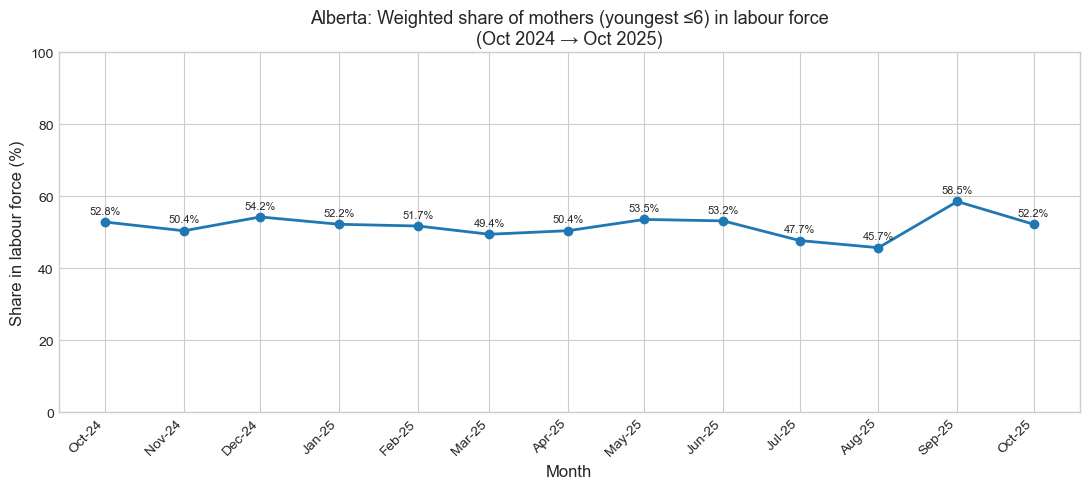

In [2]:
# Run this in Jupyter. Adjust data_dir if needed.
import os, re, warnings
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# ============ CONFIG ============
# point this to the folder where your pub*.csv files live
data_dir = os.path.expanduser('~/PycharmProjects/1400/LFS Data')  # <- change if needed
start = datetime(2024,10,1)
end   = datetime(2025,10,1)
months = pd.date_range(start=start, end=end, freq='MS')

# possible weight column names if finalwt not present
weight_candidates = ['finalwt','final_wt','final_weight','weight','wgt','pweight','pw','wt']

# core logical variables we need (we will match case-insensitively)
logical_vars = ['Prov','Gender','Lfsstat','Agyownk']

# supported extensions (we'll prefer .csv)
exts = ['.csv', '.pkl', '.feather', '.parquet', '.dta', '.xlsx', '.xls']

# =================================
if not os.path.isdir(data_dir):
    raise RuntimeError(f"data_dir not found: {data_dir}. Change the path to your folder.")

print("Scanning folder:", data_dir)
files = os.listdir(data_dir)
print(f"Found {len(files)} files. Showing up to first 50: {files[:50]}")

# regex to match pubMMYY style in filenames
pattern = re.compile(r'pub[_\-]?(\d{2})(\d{2})', flags=re.IGNORECASE)

# build mapping MMYY -> filepath (pick .csv if available)
found = {}
for fname in files:
    m = pattern.search(fname)
    if m:
        mm, yy = m.group(1), m.group(2)
        ext = os.path.splitext(fname)[1].lower()
        if ext in exts:
            key = f"{mm}{yy}"
            full = os.path.join(data_dir, fname)
            found.setdefault(key, []).append(full)

# prepare an ordered month->file mapping for the window
def key_for_date(dt):
    return f"{dt.month:02d}{dt.year%100:02d}"

month_file_map = {}
for dt in months:
    key = key_for_date(dt)
    files_for_key = found.get(key, [])
    if files_for_key:
        # prefer csv
        csvs = [f for f in files_for_key if f.lower().endswith('.csv')]
        month_file_map[key] = csvs[0] if csvs else files_for_key[0]

print("\nFile mapping for Oct-2024 -> Oct-2025:")
for dt in months:
    key = key_for_date(dt)
    print(f"  {dt.strftime('%b-%y')}: {month_file_map.get(key,'MISSING')}")

# loader function supporting csv/pkl/feather/parquet/dta/xlsx
def load_file(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.csv':
        return pd.read_csv(path, low_memory=False)
    elif ext == '.pkl':
        return pd.read_pickle(path)
    elif ext == '.feather':
        return pd.read_feather(path)
    elif ext == '.parquet':
        return pd.read_parquet(path)
    elif ext == '.dta':
        return pd.read_stata(path)
    elif ext in ('.xls', '.xlsx'):
        return pd.read_excel(path)
    else:
        raise RuntimeError(f"Unsupported extension {ext} for file {path}")

results = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        print(f"[{dt.strftime('%b-%y')}] file missing; skipping.")
        continue
    path = month_file_map[key]
    print(f"[{dt.strftime('%b-%y')}] loading: {path}")
    try:
        df = load_file(path)
    except Exception as e:
        print(f"  failed to load {path}: {e}; skipping.")
        continue

    # build lowercase col map
    cols_lower = {c.lower(): c for c in df.columns}

    # detect columns case-insensitively or via common alternates
    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    lfs_col = cols_lower.get('lfsstat') or cols_lower.get('labstat') or cols_lower.get('lfstat') or cols_lower.get('labourforce')
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    print(f"    detected -> Prov: {prov_col}, Gender: {gender_col}, Lfs: {lfs_col}, Agy: {agy_col}, weight: {wcol}")

    # if any core missing, show first 30 cols and skip
    if not all([prov_col, gender_col, lfs_col, agy_col]):
        print("    -> missing core columns; available columns (first 30):")
        print("       ", list(df.columns)[:30])
        print("    -> skipping this month.")
        continue

    # coerce relevant columns to numeric where appropriate
    for c in [prov_col, gender_col, lfs_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    # filter to Alberta, women, youngest child <=6 (Agyownk==1 per your coding)
    filt_base = (df[prov_col] == 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if filt_base.sum() == 0 and (wcol is None or df.loc[filt_base, wcol].sum() == 0):
        print("    -> no matching observations for this month; skipping.")
        continue

    if wcol:
        denom = df.loc[filt_base, wcol].sum()
        numer = df.loc[filt_base & (df[lfs_col] == 1), wcol].sum()
    else:
        denom = filt_base.sum()
        numer = (filt_base & (df[lfs_col] == 1)).sum()

    if denom in (0, 0.0) or pd.isna(denom):
        print("    -> denominator zero/NA; skipping.")
        continue

    ratio = numer / denom
    results.append({'date': dt, 'file': os.path.basename(path), 'numer_w': numer, 'denom_w': denom, 'ratio': ratio})

# summarize
if not results:
    raise RuntimeError("No months processed successfully. Check file names and column names printed above.")

res_df = pd.DataFrame(results).sort_values('date')
print("\nProcessed months:")
print(res_df[['date','file','numer_w','denom_w','ratio']].to_string(index=False))

# --- PLOT ---
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df['date'], res_df['ratio']*100, marker='o', linewidth=2)
ax.set_ylim(0,100)
ax.set_ylabel('Share in labour force (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Alberta: Weighted share of mothers (youngest ≤6) in labour force\n(Oct 2024 → Oct 2025)', fontsize=13)
ax.set_xticks(res_df['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df['date']], rotation=45, ha='right')
for x,y in zip(res_df['date'], res_df['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.tight_layout()
plt.show()
res_df_alberta = res_df.copy()


[Oct-24] loading: .\LFS Data\pub1024.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Nov-24] loading: .\LFS Data\pub1124.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Dec-24] loading: .\LFS Data\pub1224.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Jan-25] loading: .\LFS Data\pub0125.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Feb-25] loading: .\LFS Data\pub0225.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Mar-25] loading: .\LFS Data\pub0325.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[Apr-25] loading: .\LFS Data\pub0425.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT, Agy: AGYOWNK, weight: FINALWT
[May-25] loading: .\LFS Data\pub0525.csv
    detected -> Prov: PROV, Gender: GENDER, Lfs: LFSSTAT

C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\2332236692.py:133: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


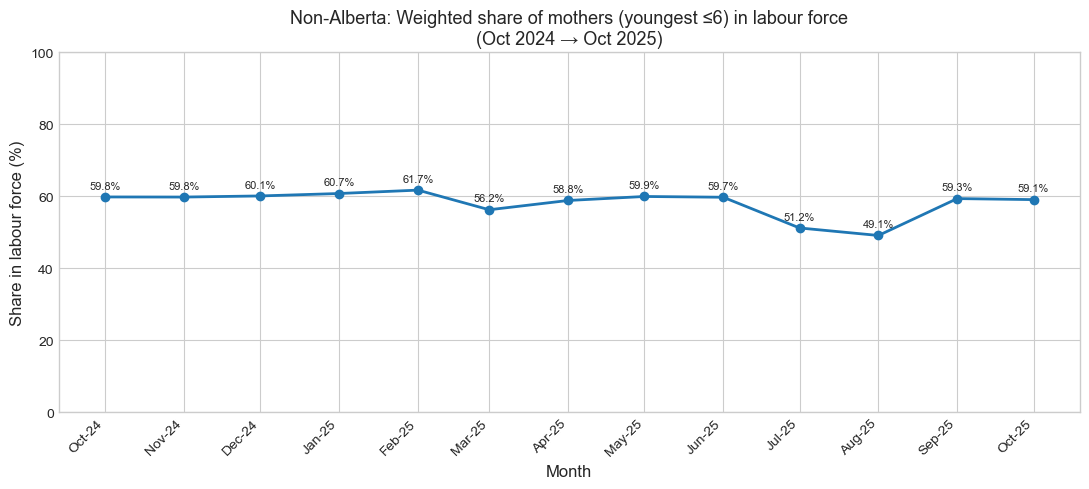

In [3]:
# Paste & run this in Jupyter (in the environment that has your pub*.csv files)
import os, re, warnings
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG: change or add the folder where your pub*.csv files live if needed ===
search_roots = [
    '.', 
    os.path.expanduser('~/PycharmProjects/1400/LFS Data'),
    os.path.expanduser('~')
]

start = datetime(2024,10,1)
end   = datetime(2025,10,1)
months = pd.date_range(start=start, end=end, freq='MS')

weight_candidates = ['finalwt','final_wt','final_weight','weight','wgt','pweight','pw','wt']
exts = ['.csv', '.pkl', '.feather', '.parquet', '.dta', '.xlsx', '.xls']
pattern = re.compile(r'pub[_\-]?(\d{2})(\d{2})', flags=re.IGNORECASE)

# find matching files under the search roots
found_files = {}
for root in search_roots:
    if not os.path.isdir(root):
        continue
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            m = pattern.search(fname)
            if m:
                ext = os.path.splitext(fname)[1].lower()
                if ext in exts:
                    key = f"{m.group(1)}{m.group(2)}"
                    full = os.path.join(dirpath, fname)
                    found_files.setdefault(key, []).append(full)

if not found_files:
    raise RuntimeError(f"No pubMMYY files found under search roots: {search_roots}. Please ensure files exist and are accessible.")

# map the months to best file (prefer CSV)
def key_for_date(dt):
    return f"{dt.month:02d}{dt.year%100:02d}"

month_file_map = {}
for dt in months:
    key = key_for_date(dt)
    files_for_key = found_files.get(key, [])
    if files_for_key:
        csvs = [f for f in files_for_key if f.lower().endswith('.csv')]
        month_file_map[key] = csvs[0] if csvs else files_for_key[0]

def load_file(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.csv':
        return pd.read_csv(path, low_memory=False)
    elif ext == '.pkl':
        return pd.read_pickle(path)
    elif ext == '.feather':
        return pd.read_feather(path)
    elif ext == '.parquet':
        return pd.read_parquet(path)
    elif ext == '.dta':
        return pd.read_stata(path)
    elif ext in ('.xls', '.xlsx'):
        return pd.read_excel(path)
    else:
        raise RuntimeError(f"Unsupported extension {ext} for file {path}")

results = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        print(f"[{dt.strftime('%b-%y')}] file missing; skipping.")
        continue
    path = month_file_map[key]
    print(f"[{dt.strftime('%b-%y')}] loading: {path}")
    try:
        df = load_file(path)
    except Exception as e:
        print(f"  failed to load {path}: {e}; skipping.")
        continue

    cols_lower = {c.lower(): c for c in df.columns}
    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    lfs_col = cols_lower.get('lfsstat') or cols_lower.get('labstat') or cols_lower.get('lfstat') or cols_lower.get('labourforce')
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    print(f"    detected -> Prov: {prov_col}, Gender: {gender_col}, Lfs: {lfs_col}, Agy: {agy_col}, weight: {wcol}")

    if not all([prov_col, gender_col, lfs_col, agy_col]):
        print("    -> missing core columns; available columns (first 30):")
        print("       ", list(df.columns)[:30])
        print("    -> skipping this month.")
        continue

    # coerce to numeric
    for c in [prov_col, gender_col, lfs_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    # FILTER: provinces != 48, female (Gender==2), Agyownk==1
    filt_base = (df[prov_col] != 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if wcol:
        denom = df.loc[filt_base, wcol].sum()
        numer = df.loc[filt_base & (df[lfs_col] == 1), wcol].sum()
    else:
        denom = filt_base.sum()
        numer = (filt_base & (df[lfs_col] == 1)).sum()

    if denom in (0,0.0) or pd.isna(denom):
        print("    -> denominator zero/NA; skipping.")
        continue

    ratio = numer / denom
    results.append({'date': dt, 'file': os.path.basename(path), 'numer_w': numer, 'denom_w': denom, 'ratio': ratio})

if not results:
    raise RuntimeError("No months processed successfully. Check file contents/columns for matching variables.")

res_df = pd.DataFrame(results).sort_values('date')
print("\nProcessed months summary (non-Alberta provinces):")
print(res_df[['date','file','numer_w','denom_w','ratio']].to_string(index=False))

# PLOT
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df['date'], res_df['ratio']*100, marker='o', linewidth=2)
ax.set_ylim(0,100)
ax.set_ylabel('Share in labour force (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Non-Alberta: Weighted share of mothers (youngest ≤6) in labour force\n(Oct 2024 → Oct 2025)', fontsize=13)
ax.set_xticks(res_df['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df['date']], rotation=45, ha='right')
for x,y in zip(res_df['date'], res_df['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.tight_layout()
plt.show()
res_df_nonalb = res_df.copy()

In [ ]:
# After running the first script (Alberta)
res_df_alberta = res_df.copy()

# After running the second script (non-Alberta)
res_df_nonalb = res_df.copy()

C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\1516324243.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


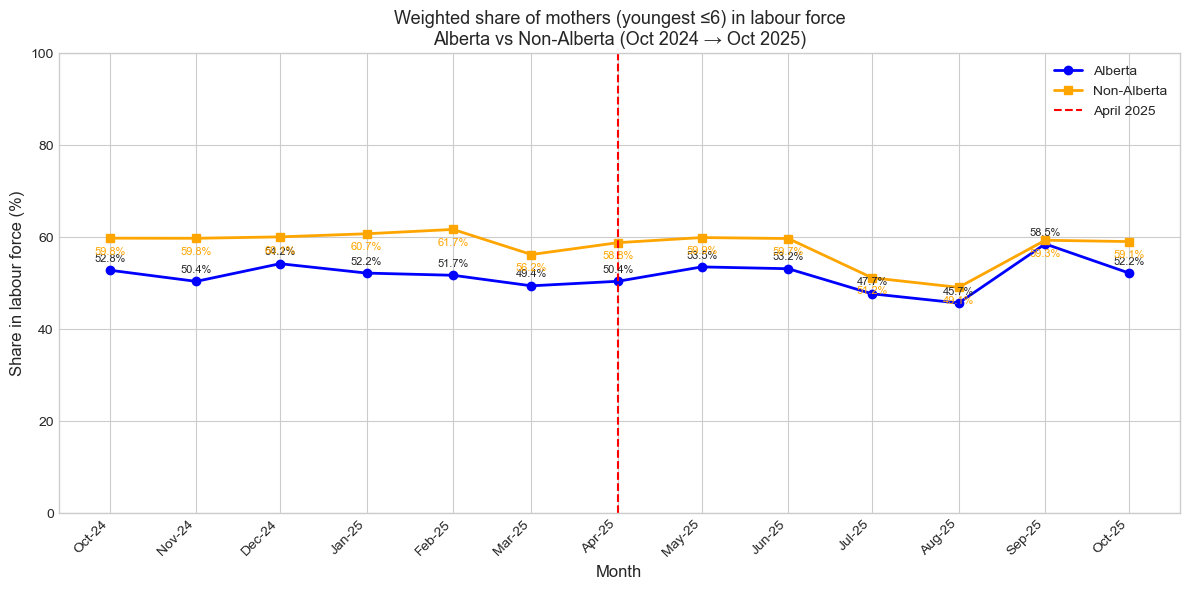

In [4]:
import matplotlib.pyplot as plt
import datetime

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12,6))

# Plot Alberta
ax.plot(res_df_alberta['date'], res_df_alberta['ratio']*100, marker='o', linewidth=2, color='blue', label='Alberta')

# Plot Non-Alberta
ax.plot(res_df_nonalb['date'], res_df_nonalb['ratio']*100, marker='s', linewidth=2, color='orange', label='Non-Alberta')

# Vertical line at April 2025
ax.axvline(datetime.datetime(2025,4,1), color='red', linestyle='--', linewidth=1.5, label='April 2025')

# Labels, title
ax.set_ylim(0,100)
ax.set_ylabel('Share in labour force (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Weighted share of mothers (youngest ≤6) in labour force\nAlberta vs Non-Alberta (Oct 2024 → Oct 2025)', fontsize=13)

# X-axis labels
all_dates = sorted(set(res_df_alberta['date']).union(res_df_nonalb['date']))
ax.set_xticks(all_dates)
ax.set_xticklabels([d.strftime('%b-%y') for d in all_dates], rotation=45, ha='right')

# Annotate points
for x, y in zip(res_df_alberta['date'], res_df_alberta['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
for x, y in zip(res_df_nonalb['date'], res_df_nonalb['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='orange')

ax.legend()
plt.tight_layout()
plt.show()


In [11]:
# After running your two scripts:
# res_df_alberta = res_df.copy()   # from script 1 (prov==48)
# res_df_nonalb = res_df.copy()    # from script 2 (prov!=48)

import pandas as pd
import statsmodels.formula.api as smf
import datetime

# Prepare datasets (make sure 'date' dtype is datetime)
res_df_alberta['date'] = pd.to_datetime(res_df_alberta['date'])
res_df_nonalb['date'] = pd.to_datetime(res_df_nonalb['date'])

# Add group label and stack
res_df_alberta2 = res_df_alberta.copy()
res_df_alberta2['group'] = 'Alberta'
res_df_nonalb2 = res_df_nonalb.copy()
res_df_nonalb2['group'] = 'NonAlberta'

df = pd.concat([res_df_alberta2, res_df_nonalb2], ignore_index=True)

# Outcome in percent (optional: you can keep ratio in [0,1] if you prefer)
df['y'] = df['ratio'] * 100

# Treatment and Post indicators
df['D'] = (df['group'] == 'Alberta').astype(int)
df['post'] = (df['date'] >= pd.to_datetime('2025-04-01')).astype(int)
df['D_post'] = df['D'] * df['post']

# Create month fixed effects variable (string or categorical)
df['month_fe'] = df['date'].dt.strftime('%Y-%m')   # or use df['date'] directly with C(date) in formula

# Simple DiD with month fixed effects
# Note: use C(month_fe) to include a dummy for each month
formula = 'y ~ D + post + D:post + C(month_fe)'
model = smf.ols(formula, data=df).fit()

print(model.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     23.65
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           3.45e-06
Time:                        20:48:17   Log-Likelihood:                -37.547
No. Observations:                  26   AIC:                             105.1
Df Residuals:                      11   BIC:                             124.0
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 60

C:\Users\Zach\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [7]:
pre = df[df['t_rel'] < 0].copy()
# create a numeric time trend (e.g., month_index)
pre['time'] = pre['month_index']
# regress y on time, D, and D*time; test H0: coef(D*time) = 0
res = smf.ols('y ~ D + time + D:time + C(month_index)', data=pre).fit(cov_type='HC1')
print(res.summary())
# the coef on D:time is the pre-trend slope differential; p-value indicates significance


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     3.098
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.147
Time:                        20:45:25   Log-Likelihood:                -13.338
No. Observations:                  12   AIC:                             42.68
Df Residuals:                       4   BIC:                             46.56
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

C:\Users\Zach\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  warnings.warn('covariance of constraints does not have full '


[Oct-24] loading: .\LFS Data\pub1024.csv
[Nov-24] loading: .\LFS Data\pub1124.csv
[Dec-24] loading: .\LFS Data\pub1224.csv
[Jan-25] loading: .\LFS Data\pub0125.csv
[Feb-25] loading: .\LFS Data\pub0225.csv
[Mar-25] loading: .\LFS Data\pub0325.csv
[Apr-25] loading: .\LFS Data\pub0425.csv
[May-25] loading: .\LFS Data\pub0525.csv
[Jun-25] loading: .\LFS Data\pub0625.csv
[Jul-25] loading: .\LFS Data\pub0725.csv
[Aug-25] loading: .\LFS Data\pub0825.csv
[Sep-25] loading: .\LFS Data\pub0925.csv
[Oct-25] loading: .\LFS Data\pub1025.csv


C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\1404167513.py:58: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


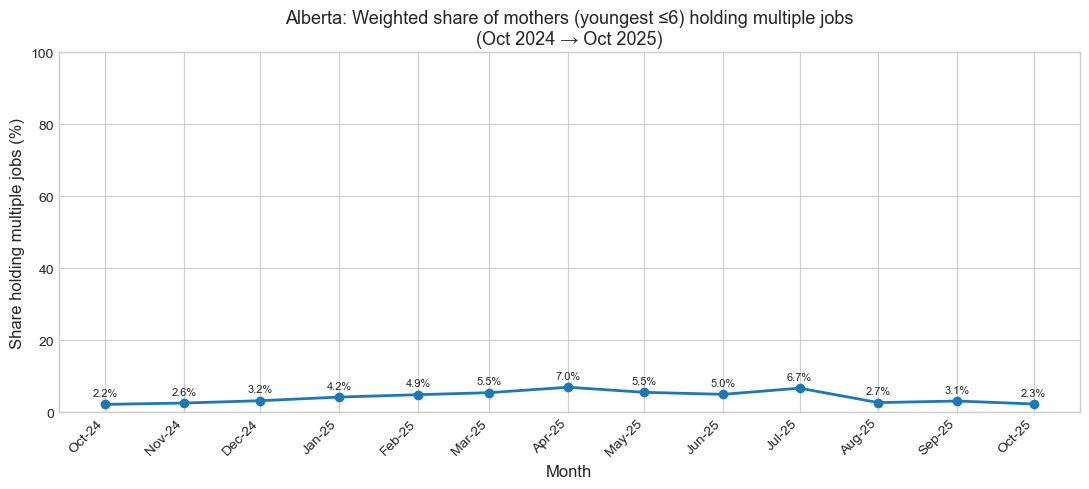

In [16]:
results_mjh = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        print(f"[{dt.strftime('%b-%y')}] file missing; skipping.")
        continue
    path = month_file_map[key]
    print(f"[{dt.strftime('%b-%y')}] loading: {path}")
    try:
        df = load_file(path)
    except Exception as e:
        print(f"  failed to load {path}: {e}; skipping.")
        continue

    # build lowercase col map
    cols_lower = {c.lower(): c for c in df.columns}

    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    mj_col = cols_lower.get('mjh')  # multiple jobs held
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    # coerce relevant columns to numeric
    for c in [prov_col, gender_col, mj_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    # filter to Alberta, women, youngest child <=6
    filt_base = (df[prov_col] == 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if filt_base.sum() == 0:
        print("    -> no matching observations for this month; skipping.")
        continue

    if wcol:
        denom = df.loc[filt_base, wcol].sum()
        numer = df.loc[filt_base & (df[mj_col] == 2), wcol].sum()  # mjh == 2
    else:
        denom = filt_base.sum()
        numer = (filt_base & (df[mj_col] == 2)).sum()

    if denom in (0, 0.0) or pd.isna(denom):
        print("    -> denominator zero/NA; skipping.")
        continue

    ratio = numer / denom
    results_mjh.append({'date': dt, 'file': os.path.basename(path), 'numer_w': numer, 'denom_w': denom, 'ratio': ratio})

res_df_mjh = pd.DataFrame(results_mjh).sort_values('date')

# --- PLOT ---
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df_mjh['date'], res_df_mjh['ratio']*100, marker='o', linewidth=2, color='tab:blue')
ax.set_ylim(0,100)
ax.set_ylabel('Share holding multiple jobs (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Alberta: Weighted share of mothers (youngest ≤6) holding multiple jobs\n(Oct 2024 → Oct 2025)', fontsize=13)
ax.set_xticks(res_df_mjh['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df_mjh['date']], rotation=45, ha='right')
for x,y in zip(res_df_mjh['date'], res_df_mjh['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.tight_layout()
plt.show()

res_df_alb_mjh = res_df_mjh.copy()

[Oct-24] loading: .\LFS Data\pub1024.csv
[Nov-24] loading: .\LFS Data\pub1124.csv
[Dec-24] loading: .\LFS Data\pub1224.csv
[Jan-25] loading: .\LFS Data\pub0125.csv
[Feb-25] loading: .\LFS Data\pub0225.csv
[Mar-25] loading: .\LFS Data\pub0325.csv
[Apr-25] loading: .\LFS Data\pub0425.csv
[May-25] loading: .\LFS Data\pub0525.csv
[Jun-25] loading: .\LFS Data\pub0625.csv
[Jul-25] loading: .\LFS Data\pub0725.csv
[Aug-25] loading: .\LFS Data\pub0825.csv
[Sep-25] loading: .\LFS Data\pub0925.csv
[Oct-25] loading: .\LFS Data\pub1025.csv


C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\1902743059.py:52: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


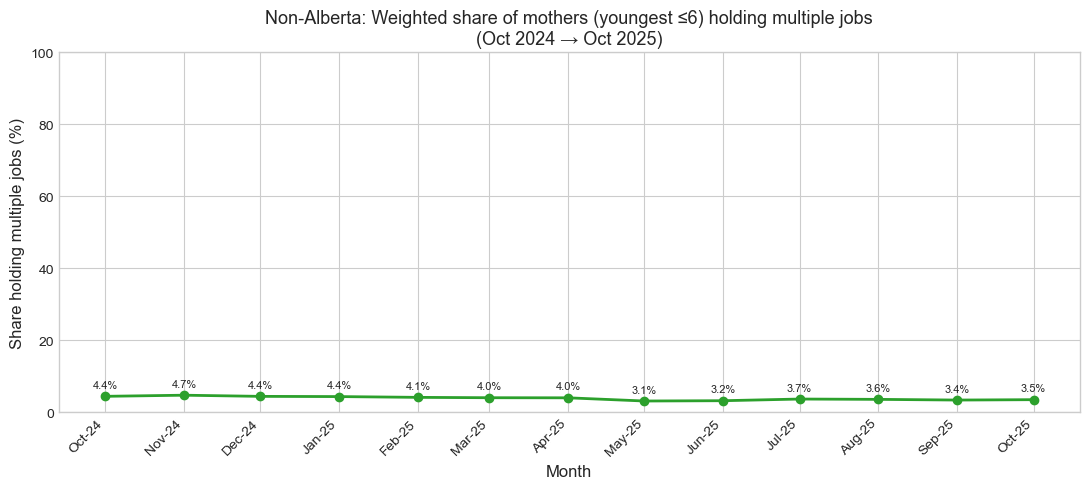

In [17]:
results_mjh_nonalb = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        print(f"[{dt.strftime('%b-%y')}] file missing; skipping.")
        continue
    path = month_file_map[key]
    print(f"[{dt.strftime('%b-%y')}] loading: {path}")
    try:
        df = load_file(path)
    except Exception as e:
        print(f"  failed to load {path}: {e}; skipping.")
        continue

    cols_lower = {c.lower(): c for c in df.columns}
    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    mj_col = cols_lower.get('mjh')  # multiple jobs held
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    # coerce numeric
    for c in [prov_col, gender_col, mj_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    # FILTER: non-Alberta provinces, female, youngest child ≤6
    filt_base = (df[prov_col] != 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if wcol:
        denom = df.loc[filt_base, wcol].sum()
        numer = df.loc[filt_base & (df[mj_col] == 2), wcol].sum()  # mjh == 2
    else:
        denom = filt_base.sum()
        numer = (filt_base & (df[mj_col] == 2)).sum()

    if denom in (0,0.0) or pd.isna(denom):
        print("    -> denominator zero/NA; skipping.")
        continue

    ratio = numer / denom
    results_mjh_nonalb.append({'date': dt, 'file': os.path.basename(path), 'numer_w': numer, 'denom_w': denom, 'ratio': ratio})

res_df_mjh_nonalb = pd.DataFrame(results_mjh_nonalb).sort_values('date')

# --- PLOT ---
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df_mjh_nonalb['date'], res_df_mjh_nonalb['ratio']*100, marker='o', linewidth=2, color='tab:green')
ax.set_ylim(0,100)
ax.set_ylabel('Share holding multiple jobs (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Non-Alberta: Weighted share of mothers (youngest ≤6) holding multiple jobs\n(Oct 2024 → Oct 2025)', fontsize=13)
ax.set_xticks(res_df_mjh_nonalb['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df_mjh_nonalb['date']], rotation=45, ha='right')
for x,y in zip(res_df_mjh_nonalb['date'], res_df_mjh_nonalb['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.tight_layout()
plt.show()
res_df_nonalb_mjh = res_df_mjh_nonalb.copy()

C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\4226851296.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


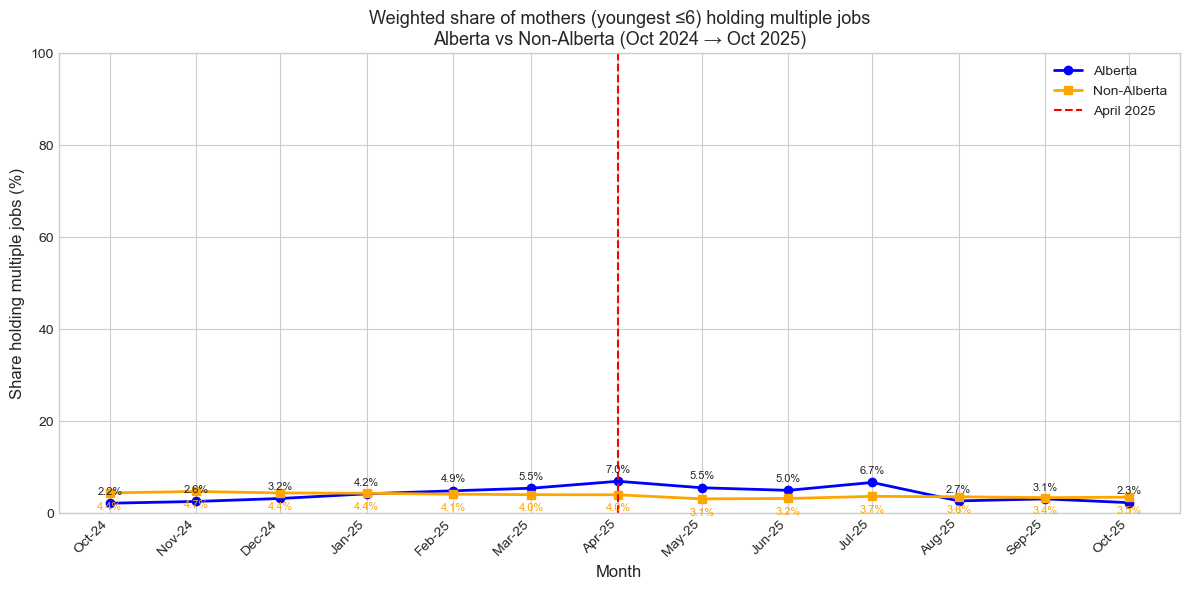

In [19]:
import matplotlib.pyplot as plt
import datetime

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12,6))

# Plot Alberta (multiple jobs)
ax.plot(res_df_alb_mjh['date'], res_df_alb_mjh['ratio']*100, marker='o', linewidth=2, color='blue', label='Alberta')

# Plot Non-Alberta (multiple jobs)
ax.plot(res_df_nonalb_mjh['date'], res_df_nonalb_mjh['ratio']*100, marker='s', linewidth=2, color='orange', label='Non-Alberta')

# Vertical line at April 2025
ax.axvline(datetime.datetime(2025,4,1), color='red', linestyle='--', linewidth=1.5, label='April 2025')

# Labels and title
ax.set_ylim(0,100)
ax.set_ylabel('Share holding multiple jobs (%)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Weighted share of mothers (youngest ≤6) holding multiple jobs\nAlberta vs Non-Alberta (Oct 2024 → Oct 2025)', fontsize=13)

# X-axis labels
all_dates = sorted(set(res_df_alb_mjh['date']).union(res_df_nonalb_mjh['date']))
ax.set_xticks(all_dates)
ax.set_xticklabels([d.strftime('%b-%y') for d in all_dates], rotation=45, ha='right')

# Annotate points
for x, y in zip(res_df_alb_mjh['date'], res_df_alb_mjh['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
for x, y in zip(res_df_nonalb_mjh['date'], res_df_nonalb_mjh['ratio']*100):
    ax.annotate(f"{y:.1f}%", (x,y), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='orange')

ax.legend()
plt.tight_layout()
plt.show()



In [20]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure date columns are datetime
res_df_alb_mjh['date'] = pd.to_datetime(res_df_alb_mjh['date'])
res_df_nonalb_mjh['date'] = pd.to_datetime(res_df_nonalb_mjh['date'])

# Add group labels
res_df_alb_mjh2 = res_df_alb_mjh.copy()
res_df_alb_mjh2['group'] = 'Alberta'

res_df_nonalb_mjh2 = res_df_nonalb_mjh.copy()
res_df_nonalb_mjh2['group'] = 'NonAlberta'

# Stack datasets
df_mjh = pd.concat([res_df_alb_mjh2, res_df_nonalb_mjh2], ignore_index=True)

# Outcome in percent
df_mjh['y'] = df_mjh['ratio'] * 100

# Treatment and post indicators
df_mjh['D'] = (df_mjh['group'] == 'Alberta').astype(int)
df_mjh['post'] = (df_mjh['date'] >= pd.to_datetime('2025-04-01')).astype(int)
df_mjh['D_post'] = df_mjh['D'] * df_mjh['post']

# Month fixed effects
df_mjh['month_fe'] = df_mjh['date'].dt.strftime('%Y-%m')  # or use C(date) directly

# DiD regression with month fixed effects
formula = 'y ~ D + post + D:post + C(month_fe)'
model = smf.ols(formula, data=df_mjh).fit()

# Robust standard errors
print(model.get_robustcov_results(cov_type='HC1').summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                    0.9006
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.581
Time:                        21:40:14   Log-Likelihood:                -30.556
No. Observations:                  26   AIC:                             91.11
Df Residuals:                      11   BIC:                             110.0
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

C:\Users\Zach\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [22]:
import statsmodels.formula.api as smf

# Ensure dates are sorted
df_mjh = df_mjh.sort_values('date').copy()
policy_date = pd.to_datetime('2025-04-01')

# Create relative time: months relative to policy_date
df_mjh['t_rel'] = (df_mjh['date'].dt.year - policy_date.year) * 12 + (df_mjh['date'].dt.month - policy_date.month)

# Numeric month index (for trend / FE)
df_mjh['month_index'] = df_mjh['date'].dt.month + 12*(df_mjh['date'].dt.year - df_mjh['date'].dt.year.min())

# Select pre-treatment period only
pre = df_mjh[df_mjh['t_rel'] < 0].copy()
pre['time'] = pre['month_index']

# Regression: outcome on D, time, D*time, plus month fixed effects
res_pre = smf.ols('y ~ D + time + D:time + C(month_index)', data=pre).fit(cov_type='HC1')

print(res_pre.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 4.243e+05
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.39e-11
Time:                        21:42:46   Log-Likelihood:                 8.6038
No. Observations:                  12   AIC:                            -1.208
Df Residuals:                       4   BIC:                             2.672
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.0253 

[Oct-24] loading: .\LFS Data\pub1024.csv
[Nov-24] loading: .\LFS Data\pub1124.csv
[Dec-24] loading: .\LFS Data\pub1224.csv
[Jan-25] loading: .\LFS Data\pub0125.csv
[Feb-25] loading: .\LFS Data\pub0225.csv
[Mar-25] loading: .\LFS Data\pub0325.csv
[Apr-25] loading: .\LFS Data\pub0425.csv
[May-25] loading: .\LFS Data\pub0525.csv
[Jun-25] loading: .\LFS Data\pub0625.csv
[Jul-25] loading: .\LFS Data\pub0725.csv
[Aug-25] loading: .\LFS Data\pub0825.csv
[Sep-25] loading: .\LFS Data\pub0925.csv
[Oct-25] loading: .\LFS Data\pub1025.csv


C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\3154070619.py:52: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


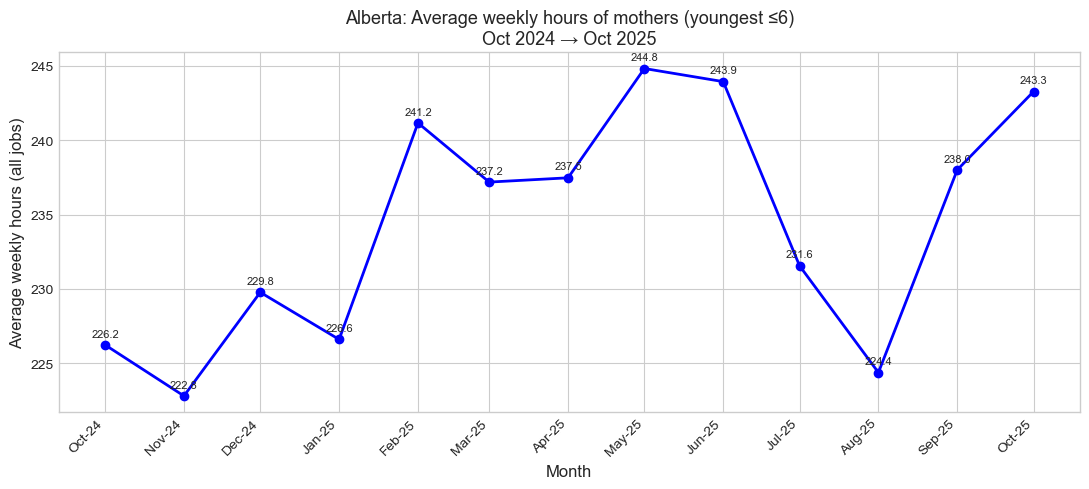

In [23]:
results_alb_utothrs = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        print(f"[{dt.strftime('%b-%y')}] file missing; skipping.")
        continue
    path = month_file_map[key]
    print(f"[{dt.strftime('%b-%y')}] loading: {path}")
    try:
        df = load_file(path)
    except Exception as e:
        print(f"  failed to load {path}: {e}; skipping.")
        continue

    cols_lower = {c.lower(): c for c in df.columns}
    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    hrs_col = cols_lower.get('utothrs')  # total hours worked
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    # coerce numeric
    for c in [prov_col, gender_col, hrs_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    # filter: Alberta, female, youngest child ≤6
    filt_base = (df[prov_col] == 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if filt_base.sum() == 0:
        print("    -> no matching observations for this month; skipping.")
        continue

    if wcol:
        total_weight = df.loc[filt_base, wcol].sum()
        mean_hrs = (df.loc[filt_base, hrs_col] * df.loc[filt_base, wcol]).sum() / total_weight
    else:
        mean_hrs = df.loc[filt_base, hrs_col].mean()

    results_alb_utothrs.append({'date': dt, 'file': os.path.basename(path), 'mean_hrs': mean_hrs})

# Save
res_df_alb_utothrs = pd.DataFrame(results_alb_utothrs).sort_values('date')

# Plot
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df_alb_utothrs['date'], res_df_alb_utothrs['mean_hrs'], marker='o', linewidth=2, color='blue')
ax.set_ylabel('Average weekly hours (all jobs)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Alberta: Average weekly hours of mothers (youngest ≤6)\nOct 2024 → Oct 2025', fontsize=13)
ax.set_xticks(res_df_alb_utothrs['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df_alb_utothrs['date']], rotation=45, ha='right')
for x, y in zip(res_df_alb_utothrs['date'], res_df_alb_utothrs['mean_hrs']):
    ax.annotate(f"{y:.1f}", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.tight_layout()
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\1339260102.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


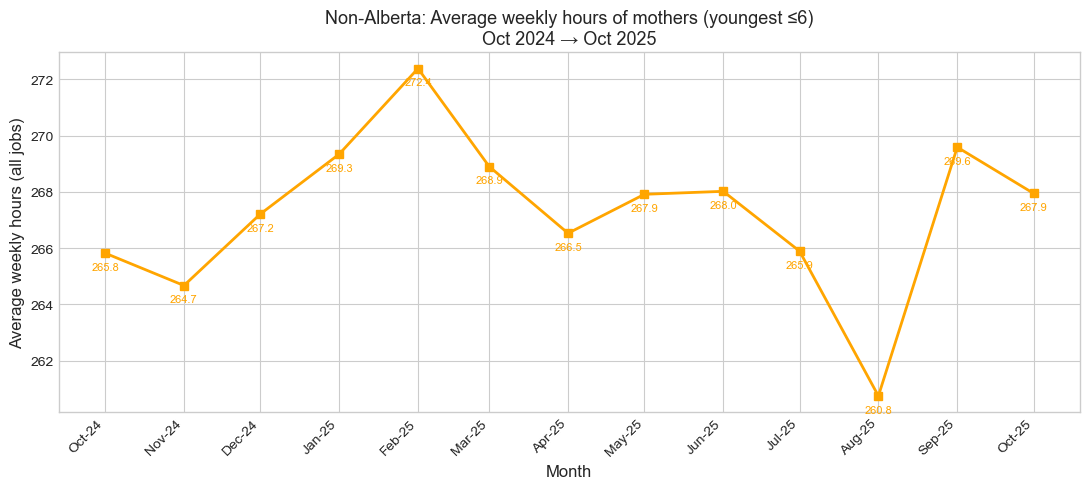

In [24]:
results_nonalb_utothrs = []
for dt in months:
    key = key_for_date(dt)
    if key not in month_file_map:
        continue
    path = month_file_map[key]
    try:
        df = load_file(path)
    except:
        continue

    cols_lower = {c.lower(): c for c in df.columns}
    prov_col = cols_lower.get('prov') or cols_lower.get('province') or cols_lower.get('prov_code') or cols_lower.get('prv')
    gender_col = cols_lower.get('gender') or cols_lower.get('sex')
    hrs_col = cols_lower.get('utothrs')
    agy_col = cols_lower.get('agyownk') or cols_lower.get('ageyoung') or cols_lower.get('age_youngest') or cols_lower.get('youngest')
    wcol = None
    for cand in weight_candidates:
        if cand in cols_lower:
            wcol = cols_lower[cand]
            break

    for c in [prov_col, gender_col, hrs_col, agy_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if wcol:
        df[wcol] = pd.to_numeric(df[wcol], errors='coerce').fillna(0.0)

    filt_base = (df[prov_col] != 48) & (df[gender_col] == 2) & (df[agy_col] == 1)

    if filt_base.sum() == 0:
        continue

    if wcol:
        total_weight = df.loc[filt_base, wcol].sum()
        mean_hrs = (df.loc[filt_base, hrs_col] * df.loc[filt_base, wcol]).sum() / total_weight
    else:
        mean_hrs = df.loc[filt_base, hrs_col].mean()

    results_nonalb_utothrs.append({'date': dt, 'file': os.path.basename(path), 'mean_hrs': mean_hrs})

# Save
res_df_nonalb_utothrs = pd.DataFrame(results_nonalb_utothrs).sort_values('date')

# Plot
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(res_df_nonalb_utothrs['date'], res_df_nonalb_utothrs['mean_hrs'], marker='s', linewidth=2, color='orange')
ax.set_ylabel('Average weekly hours (all jobs)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Non-Alberta: Average weekly hours of mothers (youngest ≤6)\nOct 2024 → Oct 2025', fontsize=13)
ax.set_xticks(res_df_nonalb_utothrs['date'])
ax.set_xticklabels([d.strftime('%b-%y') for d in res_df_nonalb_utothrs['date']], rotation=45, ha='right')
for x, y in zip(res_df_nonalb_utothrs['date'], res_df_nonalb_utothrs['mean_hrs']):
    ax.annotate(f"{y:.1f}", (x,y), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='orange')
plt.tight_layout()
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_2972\743232939.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


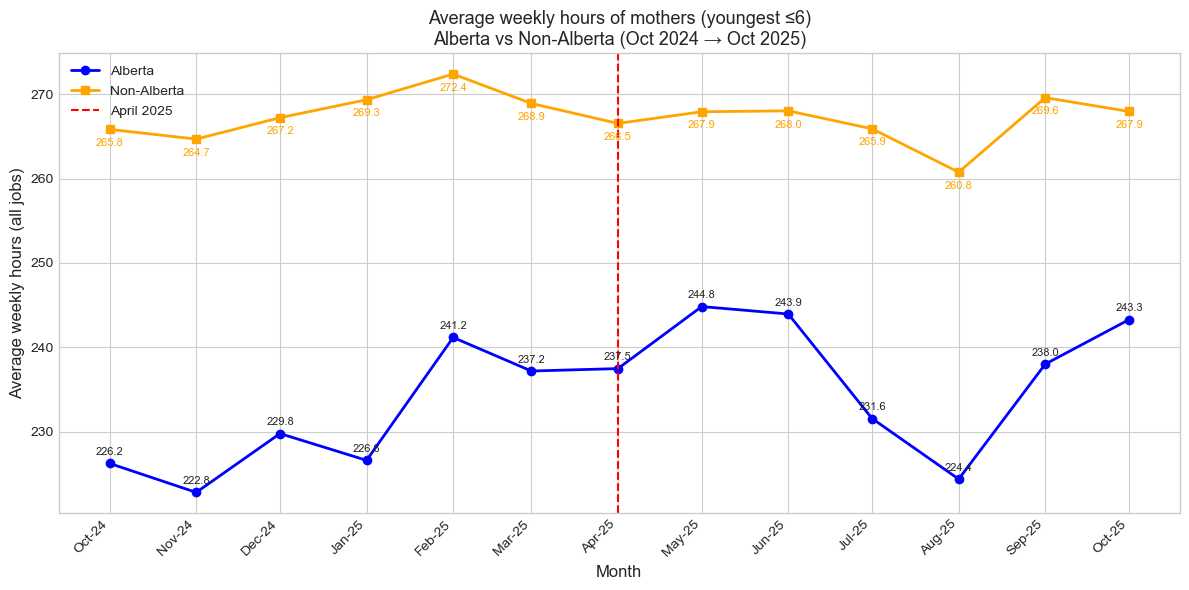

In [25]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12,6))

# Alberta
ax.plot(res_df_alb_utothrs['date'], res_df_alb_utothrs['mean_hrs'], marker='o', linewidth=2, color='blue', label='Alberta')

# Non-Alberta
ax.plot(res_df_nonalb_utothrs['date'], res_df_nonalb_utothrs['mean_hrs'], marker='s', linewidth=2, color='orange', label='Non-Alberta')

# Vertical line at April 2025
import datetime
ax.axvline(datetime.datetime(2025,4,1), color='red', linestyle='--', linewidth=1.5, label='April 2025')

ax.set_ylabel('Average weekly hours (all jobs)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Average weekly hours of mothers (youngest ≤6)\nAlberta vs Non-Alberta (Oct 2024 → Oct 2025)', fontsize=13)

all_dates = sorted(set(res_df_alb_utothrs['date']).union(res_df_nonalb_utothrs['date']))
ax.set_xticks(all_dates)
ax.set_xticklabels([d.strftime('%b-%y') for d in all_dates], rotation=45, ha='right')

for x, y in zip(res_df_alb_utothrs['date'], res_df_alb_utothrs['mean_hrs']):
    ax.annotate(f"{y:.1f}", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
for x, y in zip(res_df_nonalb_utothrs['date'], res_df_nonalb_utothrs['mean_hrs']):
    ax.annotate(f"{y:.1f}", (x,y), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='orange')

ax.legend()
plt.tight_layout()
plt.show()


In [26]:
import statsmodels.formula.api as smf
import pandas as pd

# Add group label and stack
res_df_alb_utothrs2 = res_df_alb_utothrs.copy()
res_df_alb_utothrs2['group'] = 'Alberta'

res_df_nonalb_utothrs2 = res_df_nonalb_utothrs.copy()
res_df_nonalb_utothrs2['group'] = 'NonAlberta'

df_utothrs = pd.concat([res_df_alb_utothrs2, res_df_nonalb_utothrs2], ignore_index=True)

# Outcome
df_utothrs['y'] = df_utothrs['mean_hrs']

# Treatment & post indicators
df_utothrs['D'] = (df_utothrs['group'] == 'Alberta').astype(int)
df_utothrs['post'] = (df_utothrs['date'] >= pd.to_datetime('2025-04-01')).astype(int)
df_utothrs['D_post'] = df_utothrs['D'] * df_utothrs['post']

# Month fixed effects
df_utothrs['month_fe'] = df_utothrs['date'].dt.strftime('%Y-%m')

# DiD regression
formula = 'y ~ D + post + D:post + C(month_fe)'
model_utothrs = smf.ols(formula, data=df_utothrs).fit()

# Robust SE
print(model_utothrs.get_robustcov_results(cov_type='HC1').summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     3025.
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.25e-17
Time:                        22:05:13   Log-Likelihood:                -59.294
No. Observations:                  26   AIC:                             148.6
Df Residuals:                      11   BIC:                             167.5
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                264

C:\Users\Zach\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [27]:
import statsmodels.formula.api as smf

# Ensure date sorted
df_utothrs = df_utothrs.sort_values('date').copy()

# Policy date
policy_date = pd.to_datetime('2025-04-01')

# Relative time: months relative to policy
df_utothrs['t_rel'] = (df_utothrs['date'].dt.year - policy_date.year) * 12 + (df_utothrs['date'].dt.month - policy_date.month)

# Numeric month index (for trend / fixed effects)
df_utothrs['month_index'] = df_utothrs['date'].dt.month + 12 * (df_utothrs['date'].dt.year - df_utothrs['date'].dt.year.min())

# Pre-treatment period only
pre_utothrs = df_utothrs[df_utothrs['t_rel'] < 0].copy()
pre_utothrs['time'] = pre_utothrs['month_index']

# Regression: outcome ~ D + time + D*time + month fixed effects
res_pre_utothrs = smf.ols('y ~ D + time + D:time + C(month_index)', data=pre_utothrs).fit(cov_type='HC1')

print(res_pre_utothrs.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 5.833e+04
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           7.35e-10
Time:                        22:06:01   Log-Likelihood:                -22.676
No. Observations:                  12   AIC:                             61.35
Df Residuals:                       4   BIC:                             65.23
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               93.6642 

In [28]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# --------------------------
# 1. Your directory and months
# --------------------------
data_dir = os.path.expanduser('~/PycharmProjects/1400/LFS Data')
start = datetime(2024,10,1)
end   = datetime(2025,10,1)
months = pd.date_range(start=start, end=end, freq='MS')

# regex loader info (use your existing code definitions)
# assumes month_file_map and load_file() are already defined above!

# --------------------------
# 2. Define pre-treatment window
# --------------------------
pretreat_end = datetime(2025,3,1)
pretreat_months = [dt for dt in months if dt <= pretreat_end]

# --------------------------
# 3. Possible weight names
# --------------------------
weight_candidates = ['finalwt','final_wt','final_weight','weight','wgt','pweight','pw','wt']

# --------------------------
# 4. Weighted quantile function
# --------------------------
def weighted_quantile(values, weights, quantiles):
    """Compute weighted quantiles of values with given weights."""
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]
    cum_weights = np.cumsum(weights_sorted)
    total = cum_weights[-1]
    return np.interp(np.array(quantiles)*total, cum_weights, values_sorted)

# --------------------------
# 5. Collect pre-treatment wages
# --------------------------
wages = []
weights = []

for dt in pretreat_months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    path = month_file_map.get(key)
    if path is None:
        print(f"Missing file for {dt.strftime('%b-%y')}")
        continue
    
    df = load_file(path)
    # unify column names to lowercase
    df.columns = df.columns.str.lower()

    # find weight column
    wcol = None
    for c in weight_candidates:
        if c.lower() in df.columns:
            wcol = c.lower()
            break
    if wcol is None:
        raise RuntimeError("No weight column found in this file")

    # filter to Alberta working mothers w/ youngest kid <6
    sub = df[
        (df.get('prov') == 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]

    # require wage + weight to exist
    if 'hrlyearn' not in sub.columns:
        print(f"hrlyearn missing in {path}, skipping")
        continue

    sub = sub[['hrlyearn', wcol]].dropna()
    wages.append(sub['hrlyearn'].values)
    weights.append(sub[wcol].values)

# combine
if len(wages) == 0:
    raise RuntimeError("No wage data found in pre-treatment months")

wages = np.concatenate(wages)
weights = np.concatenate(weights)

# --------------------------
# 6. Compute weighted quantiles
# --------------------------
qs = [0.1, 0.25, 0.5, 0.75, 0.9]
quant_vals = weighted_quantile(wages, weights, qs)

# print results
for q, val in zip(qs, quant_vals):
    print(f"{int(q*100)}th percentile wage: {val:.2f}")


10th percentile wage: 1774.66
25th percentile wage: 2308.00
50th percentile wage: 3365.00
75th percentile wage: 4713.76
90th percentile wage: 5769.00


In [31]:
# Pre-treatment: anything **before April 2025**
pretreat_months = [dt for dt in months if dt < datetime(2025,4,1)]

# Post-treatment: April 2025 and after
posttreat_months = [dt for dt in months if dt >= datetime(2025,4,1)]


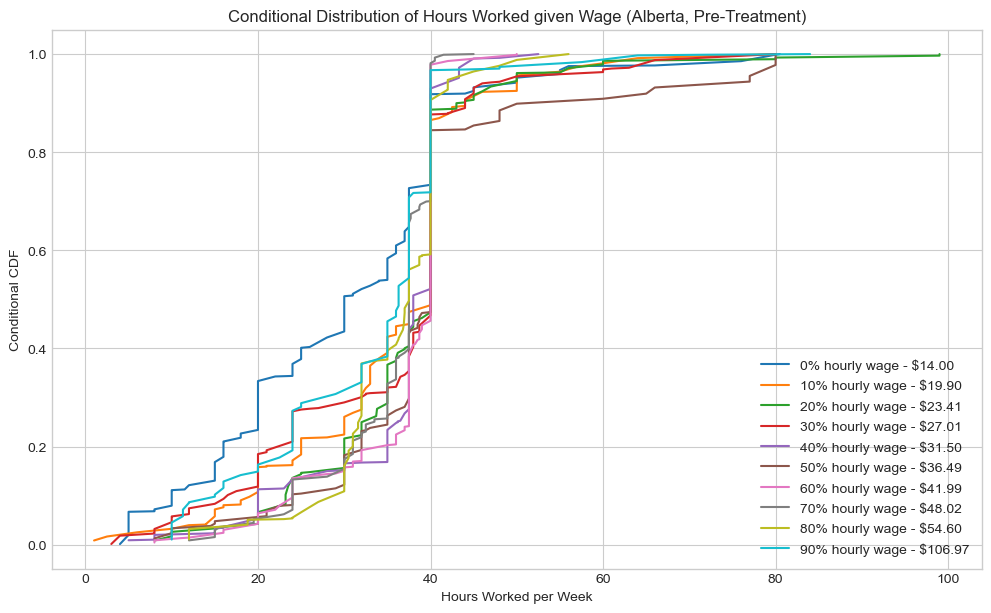

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --------------------------
# 1. Directory and months
# --------------------------
data_dir = r"C:\Users\Zach\PycharmProjects\1400\LFS Data"
start = datetime(2024,10,1)
end   = datetime(2025,3,1)  # pre-treatment
months = pd.date_range(start=start, end=end, freq='MS')

month_file_map = {
    "1024": "pub1024.csv",
    "1124": "pub1124.csv",
    "1224": "pub1224.csv",
    "0125": "pub0125.csv",
    "0225": "pub0225.csv",
    "0325": "pub0325.csv",
}

weight_candidates = ['finalwt','final_wt','final_weight','weight','wgt','pweight','pw','wt']

# --------------------------
# 2. Collect pre-treatment Alberta data
# --------------------------
all_wages, all_hours, all_weights = [], [], []

for dt in months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map.get(key)
    if file_name is None: continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path): continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    wcol = 'finalwt'  # explicitly set

    sub = df[
        (df.get('prov') == 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    if not {'hrlyearn','utothrs'}.issubset(sub.columns):
        continue

    sub = sub[['hrlyearn','utothrs',wcol]].dropna()
    if len(sub)==0: continue

    # scale wage and hours
    all_wages.append(sub['hrlyearn'].values / 100)  # e.g., 1400 -> 14.00
    all_hours.append(sub['utothrs'].values / 10)    # e.g., 400 -> 40
    all_weights.append(sub[wcol].values)

# Combine
pre_wages = np.concatenate(all_wages)
pre_hours = np.concatenate(all_hours)
pre_weights = np.concatenate(all_weights)

# --------------------------
# 3. Compute weighted conditional distribution
# --------------------------
def weighted_conditional_cdf(x_vals, y_vals, y_wts, bins=10):
    x_bins = np.quantile(x_vals, np.linspace(0, 1, bins+1))
    conditional_cdfs = []
    bin_centers = []

    for i in range(bins):
        mask = (x_vals >= x_bins[i]) & (x_vals < x_bins[i+1])
        y_bin = y_vals[mask]
        w_bin = y_wts[mask]
        if len(y_bin)==0: continue
        sorter = np.argsort(y_bin)
        y_sorted = y_bin[sorter]
        w_sorted = w_bin[sorter]
        cum_w = np.cumsum(w_sorted)/np.sum(w_sorted)
        conditional_cdfs.append((y_sorted, cum_w))
        bin_centers.append((x_bins[i]+x_bins[i+1])/2)
    return bin_centers, conditional_cdfs, x_bins

bin_centers, cond_cdfs, x_bins = weighted_conditional_cdf(pre_wages, pre_hours, pre_weights, bins=10)

# --------------------------
# 4. Visualize conditional distributions
# --------------------------
plt.figure(figsize=(12,7))
for i, (y_sorted, cum_w) in enumerate(cond_cdfs):
    percentile = int(i * 100 / len(cond_cdfs))  # approximate percentile for bin
    wage_val = bin_centers[i]
    plt.plot(y_sorted, cum_w, label=f"{percentile}% hourly wage - ${wage_val:.2f}")

plt.xlabel("Hours Worked per Week")
plt.ylabel("Conditional CDF")
plt.title("Conditional Distribution of Hours Worked given Wage (Alberta, Pre-Treatment)")
plt.legend(loc='lower right')
plt.show()


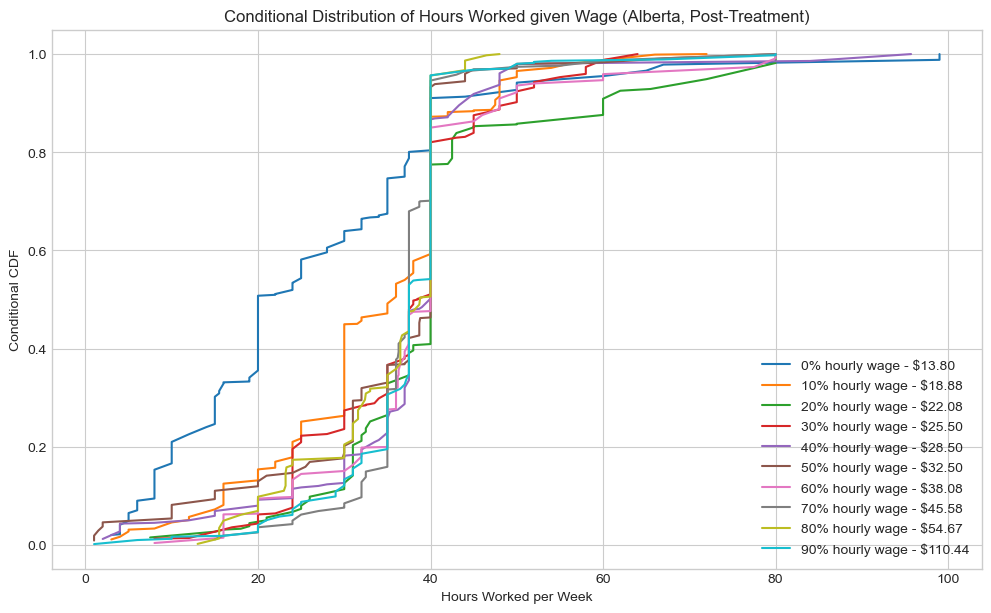

In [39]:
# --------------------------
# 1. Post-treatment months (April 2025 onward)
# --------------------------
post_start = datetime(2025,4,1)
post_end   = datetime(2025,10,1)
post_months = pd.date_range(start=post_start, end=post_end, freq='MS')

# Map of post-treatment months to files
month_file_map_post = {
    "0425": "pub0425.csv",
    "0525": "pub0525.csv",
    "0625": "pub0625.csv",
    "0725": "pub0725.csv",
    "0825": "pub0825.csv",
    "0925": "pub0925.csv",
    "1025": "pub1025.csv"
}

# Weight column
wcol = 'finalwt'

# --------------------------
# 2. Collect post-treatment Alberta data
# --------------------------
all_wages_post, all_hours_post, all_weights_post = [], [], []

for dt in post_months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map_post.get(key)
    if file_name is None: 
        print(f"Skipping missing month {key}")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    sub = df[
        (df.get('prov') == 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    if not {'hrlyearn','utothrs'}.issubset(sub.columns):
        print(f"{file_name} missing hrlyearn or utothrs")
        continue

    sub = sub[['hrlyearn','utothrs', wcol]].dropna()
    if len(sub)==0:
        print(f"No valid rows in {file_name}")
        continue

    # scale wage and hours
    all_wages_post.append(sub['hrlyearn'].values / 100)  # 1400 -> 14.00
    all_hours_post.append(sub['utothrs'].values / 10)    # 400 -> 40
    all_weights_post.append(sub[wcol].values)

# Combine arrays
if len(all_wages_post) == 0:
    raise RuntimeError("No post-treatment data found. Check files and filters.")
post_wages = np.concatenate(all_wages_post)
post_hours = np.concatenate(all_hours_post)
post_weights = np.concatenate(all_weights_post)

# --------------------------
# 3. Compute weighted conditional distribution
# --------------------------
bin_centers_post, cond_cdfs_post, _ = weighted_conditional_cdf(post_wages, post_hours, post_weights, bins=10)

# --------------------------
# 4. Visualize conditional distributions
# --------------------------
plt.figure(figsize=(12,7))
for i, (y_sorted, cum_w) in enumerate(cond_cdfs_post):
    percentile = int(i * 100 / len(cond_cdfs_post))  # approximate percentile for bin
    wage_val = bin_centers_post[i]
    plt.plot(y_sorted, cum_w, label=f"{percentile}% hourly wage - ${wage_val:.2f}")

plt.xlabel("Hours Worked per Week")
plt.ylabel("Conditional CDF")
plt.title("Conditional Distribution of Hours Worked given Wage (Alberta, Post-Treatment)")
plt.legend(loc='lower right')
plt.show()


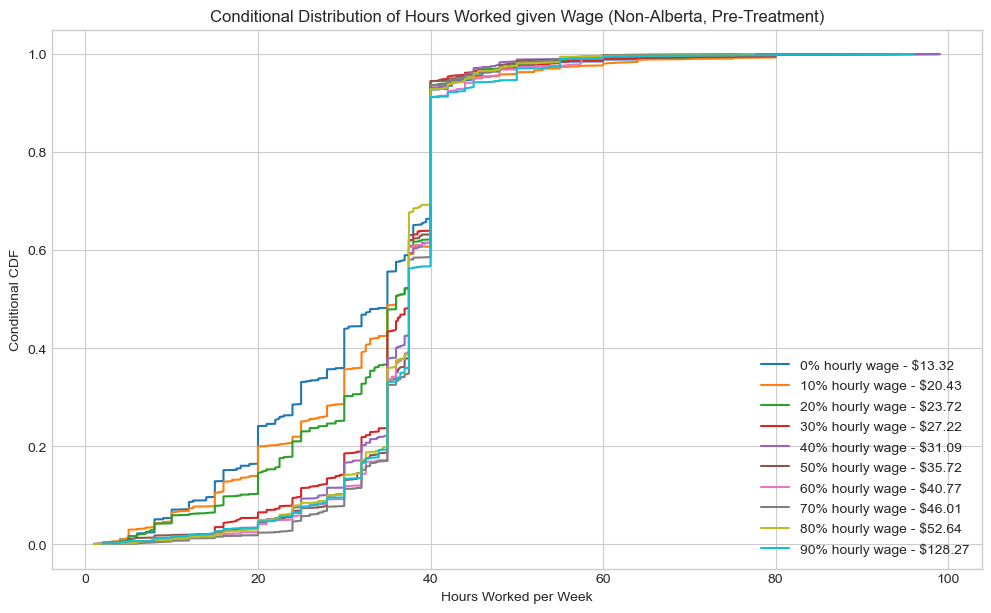

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --------------------------
# 1. Directory and months
# --------------------------
data_dir = r"C:\Users\Zach\PycharmProjects\1400\LFS Data"
start = datetime(2024,10,1)
end   = datetime(2025,3,1)  # pre-treatment
months = pd.date_range(start=start, end=end, freq='MS')

month_file_map = {
    "1024": "pub1024.csv",
    "1124": "pub1124.csv",
    "1224": "pub1224.csv",
    "0125": "pub0125.csv",
    "0225": "pub0225.csv",
    "0325": "pub0325.csv",
}

# --------------------------
# 2. Collect pre-treatment non-Alberta data
# --------------------------
all_wages, all_hours, all_weights = [], [], []
wcol = 'finalwt'  # explicitly set

for dt in months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map.get(key)
    if file_name is None: continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path): continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    sub = df[
        (df.get('prov') != 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    if not {'hrlyearn','utothrs'}.issubset(sub.columns):
        continue

    sub = sub[['hrlyearn','utothrs', wcol]].dropna()
    if len(sub)==0: continue

    # scale wage and hours
    all_wages.append(sub['hrlyearn'].values / 100)  # 1400 -> 14.00
    all_hours.append(sub['utothrs'].values / 10)    # 400 -> 40
    all_weights.append(sub[wcol].values)

# Combine
pre_wages_nonalb = np.concatenate(all_wages)
pre_hours_nonalb = np.concatenate(all_hours)
pre_weights_nonalb = np.concatenate(all_weights)

# --------------------------
# 3. Compute weighted conditional distribution
# --------------------------
def weighted_conditional_cdf(x_vals, y_vals, y_wts, bins=10):
    x_bins = np.quantile(x_vals, np.linspace(0, 1, bins+1))
    conditional_cdfs = []
    bin_centers = []

    for i in range(bins):
        mask = (x_vals >= x_bins[i]) & (x_vals < x_bins[i+1])
        y_bin = y_vals[mask]
        w_bin = y_wts[mask]
        if len(y_bin)==0: continue
        sorter = np.argsort(y_bin)
        y_sorted = y_bin[sorter]
        w_sorted = w_bin[sorter]
        cum_w = np.cumsum(w_sorted)/np.sum(w_sorted)
        conditional_cdfs.append((y_sorted, cum_w))
        bin_centers.append((x_bins[i]+x_bins[i+1])/2)
    return bin_centers, conditional_cdfs, x_bins

bin_centers_nonalb, cond_cdfs_nonalb, x_bins_nonalb = weighted_conditional_cdf(
    pre_wages_nonalb, pre_hours_nonalb, pre_weights_nonalb, bins=10
)

# --------------------------
# 4. Visualize conditional distributions
# --------------------------
plt.figure(figsize=(12,7))
for i, (y_sorted, cum_w) in enumerate(cond_cdfs_nonalb):
    percentile = int(i * 100 / len(cond_cdfs_nonalb))  # approximate percentile for bin
    wage_val = bin_centers_nonalb[i]
    plt.plot(y_sorted, cum_w, label=f"{percentile}% hourly wage - ${wage_val:.2f}")

plt.xlabel("Hours Worked per Week")
plt.ylabel("Conditional CDF")
plt.title("Conditional Distribution of Hours Worked given Wage (Non-Alberta, Pre-Treatment)")
plt.legend(loc='lower right')
plt.show()


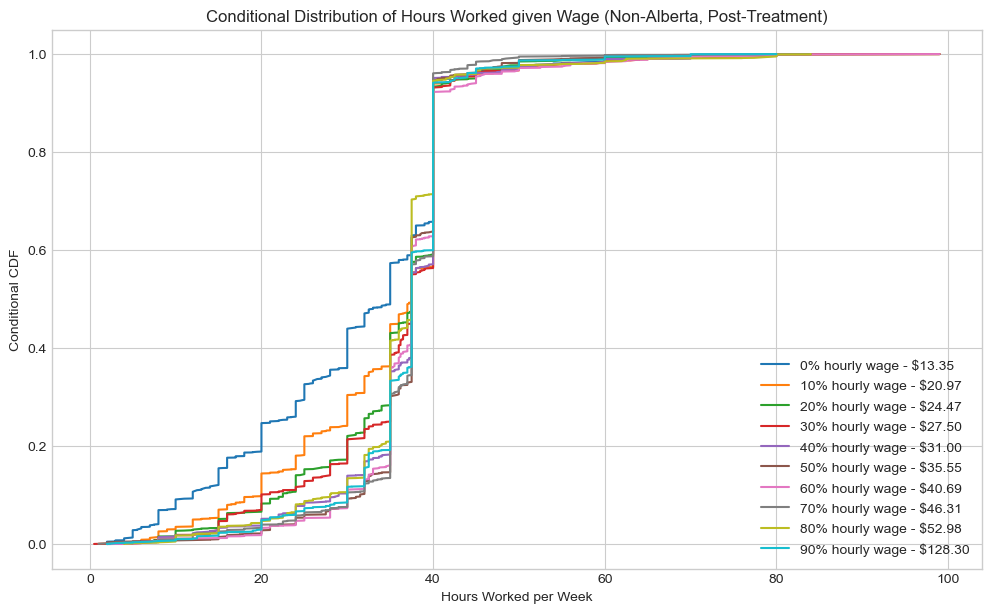

In [41]:
# --------------------------
# 1. Post-treatment months (April 2025 onward)
# --------------------------
post_start = datetime(2025,4,1)
post_end   = datetime(2025,10,1)
post_months = pd.date_range(start=post_start, end=post_end, freq='MS')

# Map of post-treatment months to files
month_file_map_post = {
    "0425": "pub0425.csv",
    "0525": "pub0525.csv",
    "0625": "pub0625.csv",
    "0725": "pub0725.csv",
    "0825": "pub0825.csv",
    "0925": "pub0925.csv",
    "1025": "pub1025.csv"
}

wcol = 'finalwt'

# --------------------------
# 2. Collect post-treatment non-Alberta data
# --------------------------
all_wages_post, all_hours_post, all_weights_post = [], [], []

for dt in post_months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map_post.get(key)
    if file_name is None: 
        print(f"Skipping missing month {key}")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    sub = df[
        (df.get('prov') != 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    if not {'hrlyearn','utothrs'}.issubset(sub.columns):
        print(f"{file_name} missing hrlyearn or utothrs")
        continue

    sub = sub[['hrlyearn','utothrs', wcol]].dropna()
    if len(sub)==0:
        print(f"No valid rows in {file_name}")
        continue

    # scale wage and hours
    all_wages_post.append(sub['hrlyearn'].values / 100)
    all_hours_post.append(sub['utothrs'].values / 10)
    all_weights_post.append(sub[wcol].values)

# Combine arrays
if len(all_wages_post) == 0:
    raise RuntimeError("No post-treatment data found. Check files and filters.")
post_wages_nonalb = np.concatenate(all_wages_post)
post_hours_nonalb = np.concatenate(all_hours_post)
post_weights_nonalb = np.concatenate(all_weights_post)

# --------------------------
# 3. Compute weighted conditional distribution
# --------------------------
bin_centers_post_nonalb, cond_cdfs_post_nonalb, _ = weighted_conditional_cdf(
    post_wages_nonalb, post_hours_nonalb, post_weights_nonalb, bins=10
)

# --------------------------
# 4. Visualize conditional distributions
# --------------------------
plt.figure(figsize=(12,7))
for i, (y_sorted, cum_w) in enumerate(cond_cdfs_post_nonalb):
    percentile = int(i * 100 / len(cond_cdfs_post_nonalb))
    wage_val = bin_centers_post_nonalb[i]
    plt.plot(y_sorted, cum_w, label=f"{percentile}% hourly wage - ${wage_val:.2f}")

plt.xlabel("Hours Worked per Week")
plt.ylabel("Conditional CDF")
plt.title("Conditional Distribution of Hours Worked given Wage (Non-Alberta, Post-Treatment)")
plt.legend(loc='lower right')
plt.show()


In [44]:
# --------------------------
# 1. Pre-treatment Alberta observations by month
# --------------------------
print("Pre-treatment Alberta observations by month:")
for dt in months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map.get(key)
    if file_name is None:
        print(f"{key}: file not found")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"{key}: file missing")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    # Filter: Alberta, female, employed, youngest child <6
    sub = df[
        (df.get('prov') == 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    n_obs = len(sub)
    print(f"{key}: {n_obs} observations")

# --------------------------
# 2. Post-treatment Alberta observations by month
# --------------------------
print("\nPost-treatment Alberta observations by month:")
for dt in post_months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map_post.get(key)
    if file_name is None:
        print(f"{key}: file not found")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"{key}: file missing")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    # Same filter
    sub = df[
        (df.get('prov') == 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    n_obs = len(sub)
    print(f"{key}: {n_obs} observations")


Pre-treatment Alberta observations by month:
1024: 259 observations
1124: 251 observations
1224: 255 observations
0125: 254 observations
0225: 238 observations
0325: 228 observations

Post-treatment Alberta observations by month:
0425: 214 observations
0525: 225 observations
0625: 218 observations
0725: 186 observations
0825: 176 observations
0925: 216 observations
1025: 184 observations


In [45]:
# --------------------------
# 1. Pre-treatment Alberta observations by month
# --------------------------
print("Pre-treatment Alberta observations by month:")
for dt in months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map.get(key)
    if file_name is None:
        print(f"{key}: file not found")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"{key}: file missing")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    # Filter: Alberta, female, employed, youngest child <6
    sub = df[
        (df.get('prov') != 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    n_obs = len(sub)
    print(f"{key}: {n_obs} observations")

# --------------------------
# 2. Post-treatment Alberta observations by month
# --------------------------
print("\nPost-treatment Alberta observations by month:")
for dt in post_months:
    key = f"{dt.month:02d}{dt.year%100:02d}"
    file_name = month_file_map_post.get(key)
    if file_name is None:
        print(f"{key}: file not found")
        continue
    path = os.path.join(data_dir, file_name)
    if not os.path.exists(path):
        print(f"{key}: file missing")
        continue

    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()

    # Same filter
    sub = df[
        (df.get('prov') != 48) &
        (df.get('gender') == 2) &
        (df.get('lfsstat') == 1) &
        (df.get('agyownk') == 1)
    ]
    n_obs = len(sub)
    print(f"{key}: {n_obs} observations")


Pre-treatment Alberta observations by month:
1024: 2745 observations
1124: 2757 observations
1224: 2716 observations
0125: 2709 observations
0225: 2816 observations
0325: 2651 observations

Post-treatment Alberta observations by month:
0425: 2741 observations
0525: 2762 observations
0625: 2723 observations
0725: 2324 observations
0825: 2219 observations
0925: 2665 observations
1025: 2708 observations


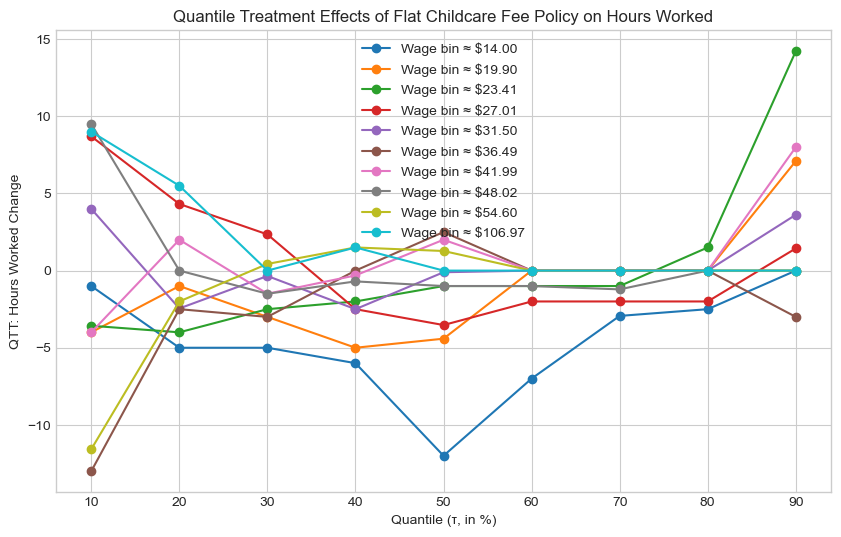

In [47]:
# --------------------------
# 1. Define quantiles of interest (every 10th percentile)
# --------------------------
taus = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.9

# --------------------------
# 3. Compute counterfactual QTT by wage bin
# --------------------------
qtt_results = {}

for i, wage_bin in enumerate(bin_centers):  # Treatment wage bins
    if i >= len(cond_cdfs) or i >= len(cond_cdfs_nonalb):
        continue

    y_treat_pre, cdf_treat_pre = cond_cdfs[i]
    y_treat_post, cdf_treat_post = cond_cdfs_post[i]
    y_ctrl_pre, cdf_ctrl_pre = cond_cdfs_nonalb[i]
    y_ctrl_post, cdf_ctrl_post = cond_cdfs_post_nonalb[i]

    y_counterfactual_post = forward_cdf_map(y_treat_pre, (y_ctrl_pre, cdf_ctrl_pre), (y_ctrl_post, cdf_ctrl_post))

    # Compute QTTs at desired quantiles
    qtt_bin = []
    for tau in taus:
        q_post = inv_cdf(y_treat_post, cdf_treat_post, tau)
        q_cf = np.interp(tau, np.linspace(0,1,len(y_counterfactual_post)), np.sort(y_counterfactual_post))
        qtt_bin.append(q_post - q_cf)

    qtt_results[wage_bin] = qtt_bin

# --------------------------
# 5. Plot QTT by quantile for each wage bin
# --------------------------
wage_bins = list(qtt_results.keys())
qtt_matrix = np.array([qtt_results[w] for w in wage_bins])  # rows=wage bins, cols=taus

plt.figure(figsize=(10,6))
for i, wage_bin in enumerate(wage_bins):
    plt.plot(taus*100, qtt_matrix[i], marker='o', label=f"Wage bin ≈ ${wage_bin:.2f}")

plt.xlabel("Quantile (τ, in %)")
plt.ylabel("QTT: Hours Worked Change")
plt.title("Quantile Treatment Effects of Flat Childcare Fee Policy on Hours Worked")
plt.legend()
plt.grid(True)
plt.show()


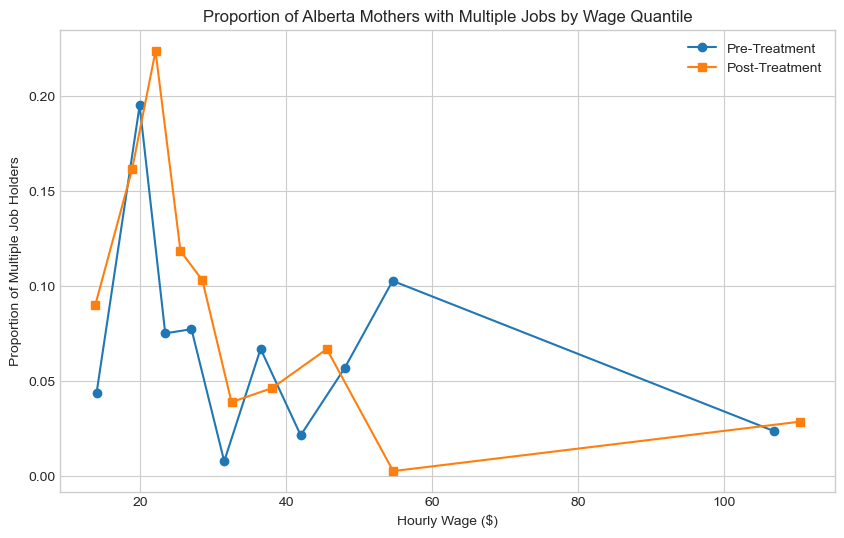

In [50]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# --------------------------
# 1. Directory and months
# --------------------------
data_dir = r"C:\Users\Zach\PycharmProjects\1400\LFS Data"

# Pre-treatment months
pre_start = datetime(2024,10,1)
pre_end   = datetime(2025,3,1)
pre_months = pd.date_range(start=pre_start, end=pre_end, freq='MS')

month_file_map_pre = {
    "1024": "pub1024.csv",
    "1124": "pub1124.csv",
    "1224": "pub1224.csv",
    "0125": "pub0125.csv",
    "0225": "pub0225.csv",
    "0325": "pub0325.csv",
}

# Post-treatment months
post_start = datetime(2025,4,1)
post_end   = datetime(2025,10,1)
post_months = pd.date_range(start=post_start, end=post_end, freq='MS')

month_file_map_post = {
    "0425": "pub0425.csv",
    "0525": "pub0525.csv",
    "0625": "pub0625.csv",
    "0725": "pub0725.csv",
    "0825": "pub0825.csv",
    "0925": "pub0925.csv",
    "1025": "pub1025.csv"
}

weight_col = 'finalwt'

# --------------------------
# 2. Function to compute ratio of mjh==2 by wage quantile
# --------------------------
def ratio_mjh_by_wage(files, months, bins=10):
    all_wages, all_mjh, all_weights = [], [], []
    
    for dt in months:
        key = f"{dt.month:02d}{dt.year%100:02d}"
        file_name = files.get(key)
        if file_name is None: continue
        path = os.path.join(data_dir, file_name)
        if not os.path.exists(path): continue
        
        df = pd.read_csv(path)
        df.columns = df.columns.str.lower()
        
        sub = df[
            (df['prov'] == 48) &
            (df['gender'] == 2) &
            (df['lfsstat'] == 1) &
            (df['agyownk'] == 1) &
            (df['mjh'].notnull()) &
            (df['hrlyearn'].notnull())
        ]
        if len(sub)==0: continue
        
        all_wages.append(sub['hrlyearn'].values / 100)  # convert to dollars
        all_mjh.append((sub['mjh']==2).astype(int).values)
        all_weights.append(sub[weight_col].values)
    
    wages = np.concatenate(all_wages)
    mjh = np.concatenate(all_mjh)
    weights = np.concatenate(all_weights)
    
    # Compute wage bins
    x_bins = np.quantile(wages, np.linspace(0,1,bins+1))
    bin_centers = []
    ratios = []
    
    for i in range(bins):
        mask = (wages >= x_bins[i]) & (wages < x_bins[i+1])
        if mask.sum()==0: continue
        bin_centers.append((x_bins[i]+x_bins[i+1])/2)
        ratios.append(np.average(mjh[mask], weights=weights[mask]))
    
    return bin_centers, ratios

# --------------------------
# 3. Calculate ratios
# --------------------------
pre_bin_centers, pre_ratios = ratio_mjh_by_wage(month_file_map_pre, pre_months)
post_bin_centers, post_ratios = ratio_mjh_by_wage(month_file_map_post, post_months)

# --------------------------
# 4. Visualize
# --------------------------
plt.figure(figsize=(10,6))
plt.plot(pre_bin_centers, pre_ratios, marker='o', label='Pre-Treatment')
plt.plot(post_bin_centers, post_ratios, marker='s', label='Post-Treatment')
plt.xlabel("Hourly Wage ($)")
plt.ylabel("Proportion of Multiple Job Holders")
plt.title("Proportion of Alberta Mothers with Multiple Jobs by Wage Quantile")
plt.legend()
plt.show()


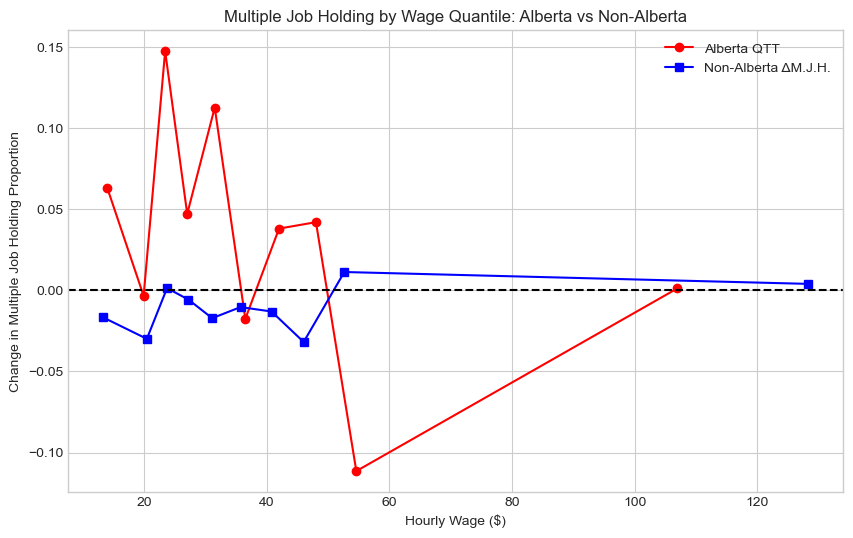

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --------------------------
# 1. Directory and months
# --------------------------
data_dir = r"C:\Users\Zach\PycharmProjects\1400\LFS Data"

pre_months_map = {
    "1024": "pub1024.csv",
    "1124": "pub1124.csv",
    "1224": "pub1224.csv",
    "0125": "pub0125.csv",
    "0225": "pub0225.csv",
    "0325": "pub0325.csv",
}

post_months_map = {
    "0425": "pub0425.csv",
    "0525": "pub0525.csv",
    "0625": "pub0625.csv",
    "0725": "pub0725.csv",
    "0825": "pub0825.csv",
    "0925": "pub0925.csv",
    "1025": "pub1025.csv"
}

weight_col = 'finalwt'

# --------------------------
# 2. Function: multiple job ratio by wage quantile
# --------------------------
def ratio_mjh_by_wage(files_map, months, province_filter, bins=10, non_alb=False):
    all_wages, all_mjh, all_weights = [], [], []
    
    for dt in months:
        key = f"{dt.month:02d}{dt.year%100:02d}"
        file_name = files_map.get(key)
        if file_name is None: continue
        path = os.path.join(data_dir, file_name)
        if not os.path.exists(path): continue
        
        df = pd.read_csv(path)
        df.columns = df.columns.str.lower()
        
        if non_alb:
            sub = df[
                (df['prov'] != 48) &
                (df['gender'] == 2) &
                (df['lfsstat'] == 1) &
                (df['agyownk'] == 1) &
                (df['mjh'].notnull()) &
                (df['hrlyearn'].notnull())
            ]
        else:
            sub = df[
                (df['prov'] == province_filter) &
                (df['gender'] == 2) &
                (df['lfsstat'] == 1) &
                (df['agyownk'] == 1) &
                (df['mjh'].notnull()) &
                (df['hrlyearn'].notnull())
            ]
        if len(sub)==0: continue
        
        # scale wages
        all_wages.append(sub['hrlyearn'].values / 100)
        all_mjh.append((sub['mjh']==2).astype(int).values)
        all_weights.append(sub[weight_col].values)
    
    if len(all_wages)==0:
        return [], [], []
    
    wages = np.concatenate(all_wages)
    mjh = np.concatenate(all_mjh)
    weights = np.concatenate(all_weights)
    
    # Wage quantile bins
    x_bins = np.quantile(wages, np.linspace(0,1,bins+1))
    bin_centers = []
    ratios = []
    
    for i in range(bins):
        mask = (wages >= x_bins[i]) & (wages < x_bins[i+1])
        if mask.sum()==0: continue
        bin_centers.append((x_bins[i]+x_bins[i+1])/2)
        ratios.append(np.average(mjh[mask], weights=weights[mask]))
    
    return bin_centers, ratios, x_bins

# --------------------------
# 3. Define months
# --------------------------
pre_months = pd.date_range(start=datetime(2024,10,1), end=datetime(2025,3,1), freq='MS')
post_months = pd.date_range(start=datetime(2025,4,1), end=datetime(2025,10,1), freq='MS')

# --------------------------
# 4. Compute ratios
# --------------------------
# Alberta (treatment)
pre_bin_centers_treat, pre_ratios_treat, wage_bins = ratio_mjh_by_wage(pre_months_map, pre_months, province_filter=48)
post_bin_centers_treat, post_ratios_treat, _ = ratio_mjh_by_wage(post_months_map, post_months, province_filter=48)

# Non-Alberta (control)
pre_bin_centers_control, pre_ratios_control, _ = ratio_mjh_by_wage(pre_months_map, pre_months, province_filter=None, non_alb=True)
post_bin_centers_control, post_ratios_control, _ = ratio_mjh_by_wage(post_months_map, post_months, province_filter=None, non_alb=True)

# --------------------------
# 5. CIC / QTT computation
# --------------------------
def cic_qtt(pre_treat, post_treat, pre_ctrl, post_ctrl):
    delta_ctrl = np.array(post_ctrl) - np.array(pre_ctrl)
    counterfactual_post = np.array(pre_treat) + delta_ctrl
    qtt = np.array(post_treat) - counterfactual_post
    return qtt, counterfactual_post

qtt, counterfactual_post = cic_qtt(pre_ratios_treat, post_ratios_treat,
                                   pre_ratios_control, post_ratios_control)

# --------------------------
# 6. Visualize QTT with control
# --------------------------
plt.figure(figsize=(10,6))

# Alberta (treatment) QTT
plt.plot(pre_bin_centers_treat, qtt, marker='o', color='red', label='Alberta QTT')

# Non-Alberta (control) actual change
control_change = np.array(post_ratios_control) - np.array(pre_ratios_control)
plt.plot(pre_bin_centers_control, control_change, marker='s', color='blue', label='Non-Alberta ΔM.J.H.')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Hourly Wage ($)")
plt.ylabel("Change in Multiple Job Holding Proportion")
plt.title("Multiple Job Holding by Wage Quantile: Alberta vs Non-Alberta")
plt.legend()
plt.show()
